In [766]:
import math
import random
import sqlite3
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [767]:
%matplotlib inline

# Init db 

In [768]:
conn = sqlite3.connect(':memory:')
c = conn.cursor()

In [769]:
c.execute('''DROP TABLE users''')

OperationalError: no such table: users

In [770]:
c.execute('''DROP TABLE queue''')

OperationalError: no such table: queue

In [771]:
c.execute('''CREATE TABLE users
             (id integer primary key, rating integer, skill integer, rd real, win integer, lose integer, draw integer)''')

In [772]:
c.execute('''CREATE TABLE queue
             (id integer primary key, rating integer, skill integer, rd real, win integer, lose integer, draw integer)''')

# Generate Users 

In [773]:
mu = 1500
sigma = 400
size = 10000
skills = np.random.normal(mu, sigma, size)

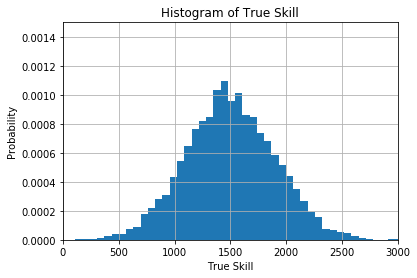

In [774]:
plt.hist(skills, 50, density=30)
plt.xlabel('True Skill')
plt.ylabel('Probability')
plt.title('Histogram of True Skill')
plt.axis([0, 3000, 0, 0.0015])
plt.grid(True)
plt.show()

In [775]:
raw_users = np.array([
    [
        _id,
        max(10, int(skill)),
        mu,
        350.0
    ]
    for _id, skill in zip(range(1, size+1), skills)
])
raw_users[:5]

array([[1.000e+00, 2.326e+03, 1.500e+03, 3.500e+02],
       [2.000e+00, 1.688e+03, 1.500e+03, 3.500e+02],
       [3.000e+00, 1.613e+03, 1.500e+03, 3.500e+02],
       [4.000e+00, 1.560e+03, 1.500e+03, 3.500e+02],
       [5.000e+00, 2.066e+03, 1.500e+03, 3.500e+02]])

# Match Functions

In [840]:
def init(users):
    c.execute("DELETE FROM users")
    conn.commit()
    
    c.executemany("INSERT INTO users (id, skill, rating, rd, win, lose, draw) VALUES (?, ?, ?, ?, 0, 0, 0)", users)
    conn.commit()

In [841]:
def enqueue(size=3000):
    c.execute("DELETE FROM queue")
    conn.commit()
    
    c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM users ORDER BY rating")
    users = c.fetchall()
    c.executemany("INSERT INTO queue (id, skill, rating, rd, win, lose, draw) VALUES (?, ?, ?, ?, ?, ?, ?)", random.sample(users, size))
    conn.commit()

In [842]:
def matchmake(match_size=2, gap=200):
    matches = []
    run_count = 0
    while True:
        run_count += 1
        c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM queue ORDER BY rating LIMIT 1")
        entry = c.fetchone()
        if not entry:
            break
        else:
            c.execute("DELETE FROM queue WHERE id = ?", (entry[0],))
            conn.commit()
        
        if run_count % 1000 == 0:
            print('run: ', run_count)

        match_found = False
        candies = [entry]
        
        c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM queue WHERE rating <= ? AND rating >= ? ORDER BY rating LIMIT 50", (entry[2]+gap, entry[2]-gap))
        entries = list(c.fetchall())
        random.shuffle(entries)
        
        for idx, candi in enumerate(entries):
            if candi[2] - 400 < entry[2] < candi[2] + 400:
                candies.append(candi)
                
            if len(candies) == match_size:
                matches.append(candies)
                match_found = True
                for el in candies:
                    c.execute("DELETE FROM queue WHERE id = ?", (el[0],))
                    conn.commit()
                break
                
        if not match_found:
            print('not found match')

    c.execute("DELETE FROM queue")
    conn.commit()

    return matches

In [843]:
def display():
    c.execute('SELECT id, skill, rating, win, lose, draw FROM users ORDER BY rating')
    res = np.array(sorted(list(c.fetchall()), key=lambda x: x[0]))
    pprint(res[-10:])
    
    user_ids = res[:, 0]
    user_skills = res[:, 1]
    user_ratings = res[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line = [min(user_skills), max(user_skills)]
    ax.plot(line, line, '--')
    ax.set_ylim([min(user_ratings)-100, max(user_ratings)+100])
    fig.tight_layout()

    plt.scatter(x=user_skills, y=user_ratings, color='g')
    plt.ylabel('rating')
    plt.xlabel('strength')
    plt.show()

# ELO

In [844]:
def get_Sa(userA, userB):
    momentum = 50
    probA = np.random.randint(low=0, high=userA[1], size=momentum)
    probB = np.random.randint(low=0, high=userB[1], size=momentum)
    
    W = 0
    D = 0
    L = 0
    for pa, pb in zip(probA, probB):
        if pa > pb:
            W += 1
        elif pa == pb:
            D += 1
        else:
            L += 1
    
    if W > L:
        return 1
    elif W == L:
        return 0.5
    else:
        return 0

In [845]:
1 / (1 + 10 ** ((1994-1706)/400))

0.16004930536524656

In [846]:
def match_elo(userA, userB):
    K = 48
    
    Ra = userA[2]
    Rb = userB[2]

    Sa = get_Sa(userA, userB)
    Sb = 1 - Sa

    Ea = 1 / (1 + 10 ** ((Rb-Ra)/400))
    Eb = 1 / (1 + 10 ** ((Ra-Rb)/400))

    return Sa, Sb, int(Ra + K * (Sa-Ea)), int(Rb + K * (Sb-Eb))

In [847]:
def match_and_update_ratings_elo(rounds):
    for i in range(rounds):
        print('epoch: ', i)
        enqueue()
        matches = matchmake()
        for userA, userB in matches:
            Sa, Sb, Ra, Rb = match_elo(userA, userB)

            aWin = userA[4] + 1 if Sa == 1 else userA[4]
            aLose = userA[5] + 1 if Sa == 0 else userA[5]
            aDraw = userA[6] + 1 if Sa == 0.5 else userA[6]

            bWin = userB[4] + 1 if Sb == 1 else userB[4]
            bLose = userB[5] + 1 if Sb == 0 else userB[5]
            bDraw = userB[6] + 1 if Sb == 0.5 else userB[6]

            c.execute("UPDATE users SET rating=?, win=?, lose=?, draw=? WHERE id=?", (Ra, aWin, aLose, aDraw, userA[0]))
            conn.commit()
            c.execute("UPDATE users SET rating=?, win=?, lose=?, draw=? WHERE id=?", (Rb, bWin, bLose, bDraw, userB[0]))
            conn.commit()

In [848]:
init(raw_users)

In [849]:
rounds = 30
match_and_update_ratings_elo(rounds)

epoch:  0
run:  1000
epoch:  1
run:  1000
epoch:  2
run:  1000
epoch:  3
run:  1000
epoch:  4
run:  1000
epoch:  5
run:  1000
epoch:  6
run:  1000
epoch:  7
run:  1000
epoch:  8
run:  1000
epoch:  9
run:  1000
epoch:  10
run:  1000
epoch:  11
run:  1000
epoch:  12
run:  1000
epoch:  13
run:  1000
epoch:  14
run:  1000
epoch:  15
run:  1000
epoch:  16
run:  1000
epoch:  17
run:  1000
epoch:  18
run:  1000
epoch:  19
run:  1000
epoch:  20
run:  1000
epoch:  21
run:  1000
epoch:  22
run:  1000
epoch:  23
run:  1000
epoch:  24
run:  1000
epoch:  25
run:  1000
epoch:  26
run:  1000
epoch:  27
run:  1000
epoch:  28
run:  1000
epoch:  29
run:  1000


array([[ 9991,  1461,  1455,     3,     5,     1],
       [ 9992,  1964,  1597,     7,     3,     2],
       [ 9993,   881,  1405,     2,     6,     1],
       [ 9994,  2375,  1646,     8,     2,     0],
       [ 9995,  1574,  1481,     2,     3,     0],
       [ 9996,  1645,  1500,     4,     4,     0],
       [ 9997,  1528,  1480,     4,     5,     0],
       [ 9998,  1713,  1479,     3,     4,     1],
       [ 9999,  1483,  1504,     6,     6,     0],
       [10000,   973,  1429,     2,     5,     0]])


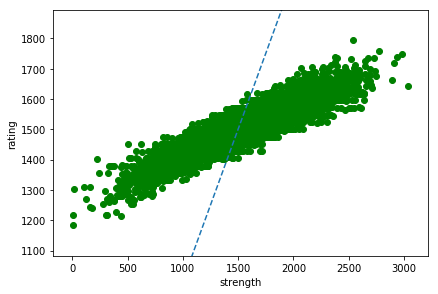

In [850]:
display()

In [851]:
rounds = 60
match_and_update_ratings_elo(rounds)

epoch:  0
run:  1000
epoch:  1
run:  1000
epoch:  2
run:  1000
epoch:  3
run:  1000
epoch:  4
run:  1000
epoch:  5
run:  1000
epoch:  6
run:  1000
epoch:  7
run:  1000
epoch:  8
run:  1000
epoch:  9
run:  1000
epoch:  10
run:  1000
epoch:  11
run:  1000
epoch:  12
run:  1000
epoch:  13
run:  1000
epoch:  14
run:  1000
epoch:  15
run:  1000
epoch:  16
run:  1000
epoch:  17
run:  1000
epoch:  18
run:  1000
epoch:  19
run:  1000
epoch:  20
run:  1000
epoch:  21
run:  1000
epoch:  22
run:  1000
epoch:  23
run:  1000
epoch:  24
run:  1000
epoch:  25
run:  1000
epoch:  26
run:  1000
epoch:  27
run:  1000
epoch:  28
run:  1000
epoch:  29
run:  1000
epoch:  30
run:  1000
epoch:  31
run:  1000
epoch:  32
run:  1000
epoch:  33
run:  1000
epoch:  34
run:  1000
epoch:  35
run:  1000
epoch:  36
run:  1000
epoch:  37
run:  1000
epoch:  38
run:  1000
epoch:  39
run:  1000
epoch:  40
run:  1000
epoch:  41
run:  1000
epoch:  42
run:  1000
epoch:  43
run:  1000
epoch:  44
run:  1000
epoch:  45
run:  100

array([[ 9991,  1461,  1473,    14,    15,     3],
       [ 9992,  1964,  1589,    16,    12,     2],
       [ 9993,   881,  1265,     7,    16,     3],
       [ 9994,  2375,  1764,    17,     6,     2],
       [ 9995,  1574,  1451,     9,    11,     3],
       [ 9996,  1645,  1521,    12,    11,     2],
       [ 9997,  1528,  1520,    14,    13,     2],
       [ 9998,  1713,  1518,    12,    11,     4],
       [ 9999,  1483,  1472,    15,    16,     1],
       [10000,   973,  1333,     7,    14,     1]])


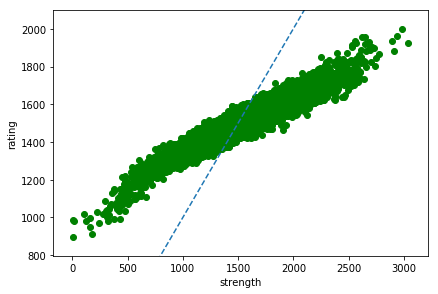

In [852]:
display()

# Glicko2

In [812]:
SIGMA = 0.06
SCALE = 173.7178

In [813]:
def scale_down(user):
    return [(user[2]-1500)/SCALE, user[3]/SCALE]

def scale_up(mu, RD):
    return [SCALE*mu+1500, SCALE*RD]

In [814]:
def g(RD):
    return 1 / math.sqrt(1 + 3*math.pow(RD, 2) / math.pi**2)

def E(mu, muj, RDj):
    return 1 / (1 + math.exp(-1*g(RDj)*(mu-muj)))

def compute_v(mu, muj, RDj):
    expected = E(mu, muj, RDj)
    return 1 / (g(RDj)**2 * expected * (1 - expected))

In [815]:
pprint(scale_down([1, 1500, 1500, 200]))
pprint(scale_down([2, 1400, 1400, 30]))

[0.0, 1.1512924985234674]
[-0.5756462492617337, 0.1726938747785201]


In [816]:
pprint(scale_up(0, 1.1512924985234674))
pprint(scale_up(-0.5756462492617337, 0.1726938747785201))

[1500.0, 200.0]
[1400.0, 30.000000000000004]


In [817]:
g(0.1726938747785201)

0.9954980064506083

In [818]:
E(0, -0.5756462492617337, 0.1726938747785201)

0.6394677305521533

In [819]:
compute_v(0, -0.5756462492617337, 0.1726938747785201)

4.376797309217415

In [827]:
def compute_RD_dash(RD, v):
    RD_star = math.sqrt(RD**2 + SIGMA**2)
    return 1 / math.sqrt(1/(RD_star**2) + 1/v)

def compute_mu_dash(mu, RD_dash, muj, RDj, S):
    return mu + RD_dash**2 * g(RDj) * (S - E(mu, muj, RDj))

In [828]:
compute_RD_dash(1.1512924985234674, compute_v(0, -0.5756462492617337, 0.1726938747785201))

1.0096988569619971

In [829]:
compute_mu_dash(0, 1.0086487113987017, -0.5756462492617337, 0.1726938747785201, 1)

0.36514420538471803

In [830]:
def match_glicko(userA, userB):
    S1 = get_Sa(userA, userB)
    S2 = 1 - S1
    
    mu1, RD1 = scale_down(userA)
    mu2, RD2 = scale_down(userB)
        
    v1 = compute_v(mu1, mu2, RD2)
    RD_dash1 = compute_RD_dash(RD1, v1)
    mu_dash1 = compute_mu_dash(mu1, RD_dash1, mu2, RD2, S1)
    
    v2 = compute_v(mu2, mu1, RD1)
    RD_dash2 = compute_RD_dash(RD2, v2)
    mu_dash2 = compute_mu_dash(mu2, RD_dash2, mu1, RD1, S2)
    
    return ([S1] + scale_up(mu_dash1, RD_dash1)), ([S2] + (scale_up(mu_dash2, RD_dash2)))

In [831]:
def match_and_update_ratings_glicko(rounds):
    for i in range(rounds):
        print('epoch: ', i)
        enqueue()
        matches = matchmake()
        for userA, userB in matches:
            R1, R2 = match_glicko(userA, userB)
            
            (S1, mu1, RD1) = R1
            (S2, mu2, RD2) = R2

            aWin = userA[4] + 1 if S1 == 1 else userA[4]
            aLose = userA[5] + 1 if S1 == 0 else userA[5]
            aDraw = userA[6] + 1 if S1 == 0.5 else userA[6]

            bWin = userB[4] + 1 if S2 == 1 else userB[4]
            bLose = userB[5] + 1 if S2 == 0 else userB[5]
            bDraw = userB[6] + 1 if S2 == 0.5 else userB[6]

            c.execute("UPDATE users SET rating=?, RD=?, win=?, lose=?, draw=? WHERE id=?", (int(mu1), RD1, aWin, aLose, aDraw, userA[0]))
            conn.commit()
            c.execute("UPDATE users SET rating=?, RD=?, win=?, lose=?, draw=? WHERE id=?", (int(mu2), RD2, bWin, bLose, bDraw, userB[0]))
            conn.commit()

In [853]:
init(raw_users)

In [854]:
rounds = 30
match_and_update_ratings_glicko(rounds)

epoch:  0
run:  1000
epoch:  1
run:  1000
epoch:  2
run:  1000
epoch:  3
run:  1000
epoch:  4
run:  1000
epoch:  5
run:  1000
epoch:  6
run:  1000
epoch:  7
run:  1000
epoch:  8
run:  1000
epoch:  9
run:  1000
epoch:  10
run:  1000
epoch:  11
run:  1000
epoch:  12
run:  1000
epoch:  13
run:  1000
epoch:  14
run:  1000
epoch:  15
run:  1000
epoch:  16
run:  1000
epoch:  17
run:  1000
epoch:  18
run:  1000
epoch:  19
run:  1000
epoch:  20
run:  1000
epoch:  21
run:  1000
epoch:  22
run:  1000
epoch:  23
run:  1000
epoch:  24
run:  1000
epoch:  25
run:  1000
epoch:  26
run:  1000
epoch:  27
run:  1000
epoch:  28
run:  1000
epoch:  29
run:  1000


array([[ 9991,  1461,  1571,     4,     5,     1],
       [ 9992,  1964,  2059,     5,     0,     0],
       [ 9993,   881,  1010,     1,     6,     0],
       [ 9994,  2375,  1985,     6,     1,     1],
       [ 9995,  1574,  1682,     3,     4,     1],
       [ 9996,  1645,  1711,     4,     4,     1],
       [ 9997,  1528,  1454,     5,     4,     1],
       [ 9998,  1713,  1669,     5,     3,     0],
       [ 9999,  1483,  1382,     4,     5,     1],
       [10000,   973,  1137,     2,     6,     1]])


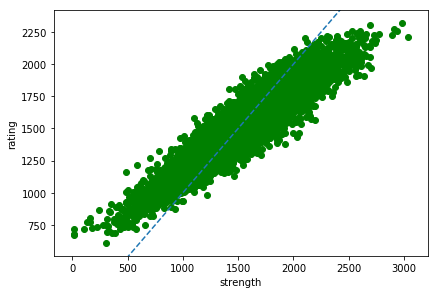

In [855]:
display()

In [856]:
rounds = 60
match_and_update_ratings_glicko(rounds)

epoch:  0
run:  1000
epoch:  1
run:  1000
epoch:  2
run:  1000
epoch:  3
run:  1000
epoch:  4
run:  1000
epoch:  5
run:  1000
epoch:  6
run:  1000
epoch:  7
run:  1000
epoch:  8
run:  1000
epoch:  9
run:  1000
epoch:  10
run:  1000
epoch:  11
run:  1000
epoch:  12
run:  1000
epoch:  13
run:  1000
epoch:  14
run:  1000
epoch:  15
run:  1000
epoch:  16
run:  1000
epoch:  17
run:  1000
epoch:  18
run:  1000
epoch:  19
run:  1000
epoch:  20
run:  1000
epoch:  21
run:  1000
epoch:  22
run:  1000
epoch:  23
run:  1000
epoch:  24
run:  1000
epoch:  25
run:  1000
epoch:  26
run:  1000
epoch:  27
run:  1000
epoch:  28
run:  1000
epoch:  29
run:  1000
epoch:  30
run:  1000
epoch:  31
run:  1000
epoch:  32
run:  1000
epoch:  33
run:  1000
epoch:  34
run:  1000
epoch:  35
run:  1000
epoch:  36
run:  1000
epoch:  37
run:  1000
not found match
not found match
epoch:  38
run:  1000
epoch:  39
run:  1000
epoch:  40
run:  1000
epoch:  41
run:  1000
epoch:  42
run:  1000
epoch:  43
run:  1000
epoch:  44

array([[ 9991,  1461,  1497,    11,    14,     3],
       [ 9992,  1964,  1893,    11,     9,     2],
       [ 9993,   881,  1026,     8,    13,     0],
       [ 9994,  2375,  2169,    18,     6,     6],
       [ 9995,  1574,  1590,     9,    13,     1],
       [ 9996,  1645,  1566,    10,    15,     2],
       [ 9997,  1528,  1459,    10,     9,     5],
       [ 9998,  1713,  1591,    12,    11,     2],
       [ 9999,  1483,  1370,    12,    14,     2],
       [10000,   973,  1078,     9,    14,     5]])


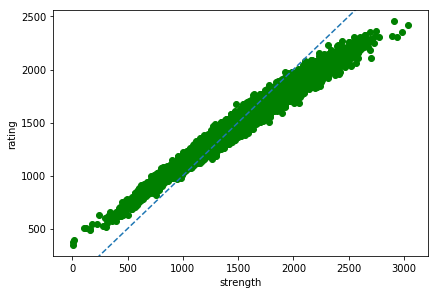

In [857]:
display()